In [1]:
# general
from specparam import SpectralModel
from specparam.sim import sim_power_spectrum
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# local
import sys
sys.path.append('../..')
from allen_vc.utils import knee_freq

# autoreload
%load_ext autoreload
%autoreload 2

print("Packages Imported")

Packages Imported


In [2]:
# load sample lfp data
all_chan_spectra = np.load("G:/Shared drives/visual_encoding/data/lfp_data/spectra/psd/natural_movie_one_more_repeats/spectra_766640955.npz")
freq, all_chan_psd = all_chan_spectra['freq'], all_chan_spectra['spectra']
spectra = all_chan_psd[0,6,:] # single channel

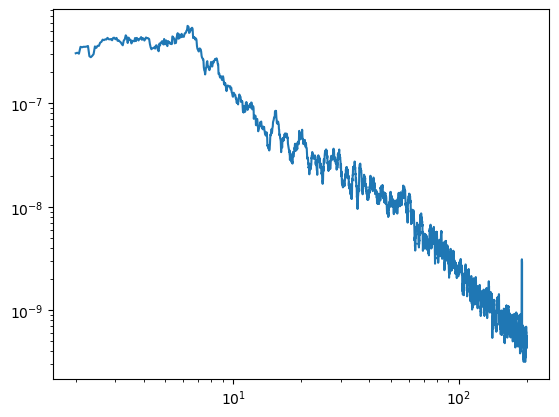

In [3]:
plt.loglog(freq, spectra)

In [4]:
# fooof settings
N_JOBS = -1 # number of jobs for parallel processing, psd_array_multitaper()
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [2, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0, # (default: 0) 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2, # (default: 2.0)
    'aperiodic_mode'    :   'knee',
    'verbose'           :   False}

In [5]:
# fooof parameterization
f = SpectralModel(**SPEC_PARAM_SETTINGS)
f.set_check_data_mode(False)
f._check_freqs = False
f.fit(freq, spectra)

In [17]:
offset = f.get_params('aperiodic_params', 'offset')
exp = f.get_params('aperiodic_params', 'exponent')
knee = f.get_params('aperiodic_params', 'knee')
knee_hz = knee_freq(knee, exp)

print(f"Offset: \t{offset:.1f}, \
      \nExponent: \t{exp:.1f}, \
      \nKnee: \t\t{knee:.1f}, \
      \nknee freq: \t{knee_hz:.1f} Hz")

Offset: 	-4.8,       
Exponent: 	1.9,       
Knee: 		50.1,       
knee freq: 	7.6 Hz


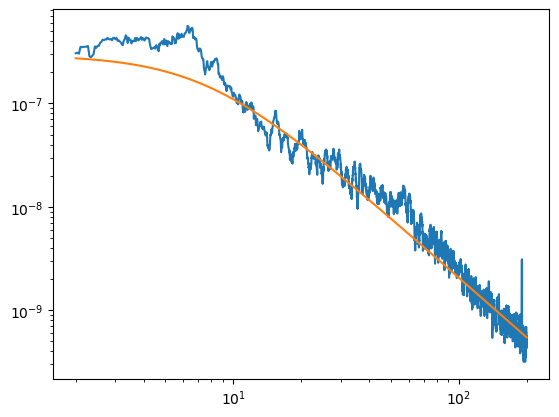

In [58]:
# simulate aperiodic fit - custom

# ap_params = f.get_params('aperiodic_params')
# aperiodic_fit = ap_params[0] - np.log10(ap_params[1] + freq**ap_params[2])
aperiodic_fit = offset - np.log10(knee + freq**exp)
plt.loglog(freq, spectra)
plt.loglog(freq, 10**aperiodic_fit)

In [8]:
# simulate aperiodic fit - specparam

sim_params = {
    'freq_range': [freq[0], freq[-1]],
    'aperiodic_params': f.get_params('aperiodic_params'),
    'periodic_params': [],
    'nlv': 0
}

# sim_freqs, sim_spectra = sim_power_spectrum(**sim_params)
sim_freqs, sim_spectra = sim_power_spectrum(**sim_params)

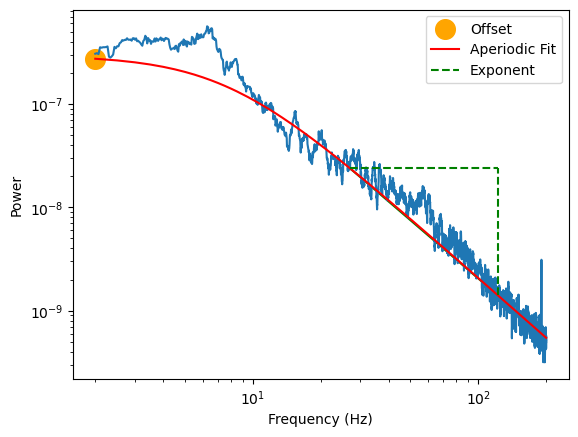

In [9]:
idxs = [50, 240]
x1, y1 = sim_freqs[idxs[0]], sim_spectra[idxs[0]]
x2, y2 = sim_freqs[idxs[1]], sim_spectra[idxs[1]]

# empirical data
plt.loglog(freq, spectra)

# offset
plt.scatter(sim_freqs[0], sim_spectra[0], color='orange', label='Offset',s=200)

# aperiodic fit
plt.loglog(sim_freqs, sim_spectra, label='Aperiodic Fit', color='red')

# exponent
plt.plot((x1, x2),(y1, y1), color='green', linestyle='--', label='Exponent')
plt.plot((x2, x2),(y2, y1), color='green', linestyle='--')
plt.plot((x1, x2),(y1, y2), color='green', linestyle='-', zorder=0)


# stuffs
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend();

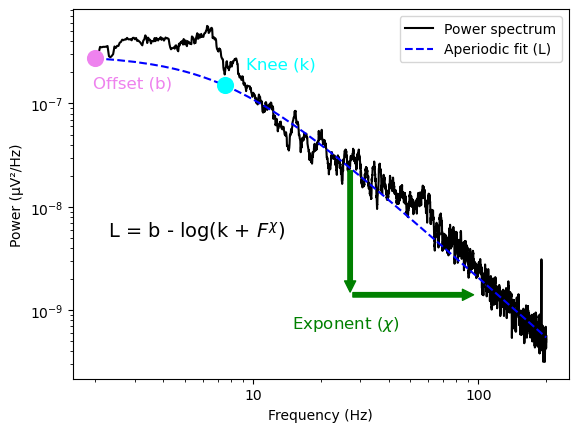

In [73]:
# plot model - # USE PLOTTING STYLE FOR SFN

# settings
colors = ['b','violet','cyan','g'] # CAN DIVERSITY COLORS TO DISTINGUISH FEATURES

# create figure
fig, ax = plt.subplots()

# empirical data
ax.loglog(freq, spectra, color='k', label="Power spectrum", zorder=0)

# aperiodic fit
ax.loglog(sim_freqs, sim_spectra, color=colors[0], linestyle='--', label='Aperiodic fit (L)', zorder=1)

# offset
ax.scatter(sim_freqs[0], sim_spectra[0], color=colors[1], s=128, zorder=2)

# knee 
idx_knee = np.argmin(np.abs(sim_freqs-knee_hz))
ax.scatter(sim_freqs[idx_knee], sim_spectra[idx_knee], color=colors[2], s=128, zorder=2)

# exponent - THIS CAN BE ADJUSTED TO STYLE
idxs = [50, 240]
x1, y1 = sim_freqs[idxs[0]], sim_spectra[idxs[0]]
x2, y2 = sim_freqs[idxs[1]], sim_spectra[idxs[1]]
ax.add_patch(mpatches.FancyArrowPatch((x1, y1), (x1, y2), mutation_scale=16, color=colors[3]))
# ax.add_patch(mpatches.FancyArrowPatch((x1, y2), (x2, y2), mutation_scale=16, color=colors[1]))
ax.add_patch(mpatches.FancyArrowPatch((x1, y2), (98, y2), mutation_scale=16, color=colors[3]))

# labels
ax.set_xticks([10, 100], labels=['10', '100'])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (\u03BCV\u00b2/Hz)') # CHECK LFP VOLTAGE IS uV
ax.legend()

# aperiodic annotation
ax.text(0.12, 0.8, 'Offset (b)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=colors[1], fontsize=12)
ax.text(0.42, 0.85, 'Knee (k)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=colors[2], fontsize=12)
ax.text(0.55, 0.15, 'Exponent ($\chi$)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=colors[3], fontsize=12)

# equation 
ax.text(0.25, 0.4, 'L = b - log(k + $F^\chi$)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='k', fontsize=14)

plt.show()

NameError: name 'off' is not defined

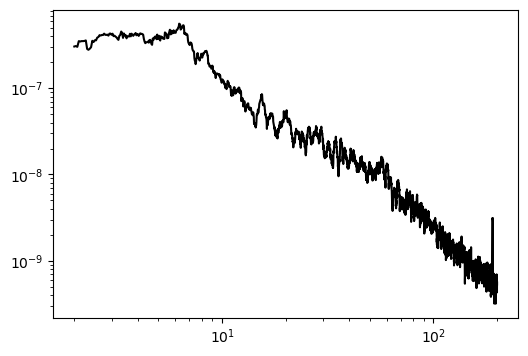

In [11]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.loglog(freq, spectra, color='k', label="power spectrum", zorder=0)
ax.set(xlabel="", ylabel="")
ax.set_title("")

ax.axhline(off)
print(off)

plt.show()